# 2024 드라마

In [7]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [8]:
df = pd.read_csv('./data_drama/2024년 방영 드라마.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20240510,안녕하세요! 오늘은 평소와 다르게 중국 드라마에 대해 설명 드리려고 합니다. 치아문...,직접 <b>2024년<\/b> 곧 <b>방영<\/b> 예정인 <b>드라마<\/b> ...,"중국 드라마 추천 2024년 방영 예정작 4편_ 로맨스, 학원물편"
1,20240112,MBC에 이어 SBS도 2024년 드라마 라인업을 공개했습니다. [2023 SBS ...,MBC에 이어 SBS도 <b>2024년<\/b> <b>드라마<\/b> 라인업을 공개...,"2024년 SBS 드라마 라인업 8편 '7인의 부활', '강매강', '인사하는 사이..."
2,20240416,안녕하세요 리을입니다. 오늘은 2024년 4월 1일부터 4월 15일까지 방송된 드라...,오늘은 <b>2024년<\/b> 4월 1일부터 4월 15일까지 방송된 <b>드라마<...,2024년 4월 드라마 시청률 순위와 5월 방영 공개 예정 작품 살펴 보기
3,20240430,* 편성은 언제나 변경될 수 있으며 이 포스팅은 / 을 기준으로 작성된 이후 수정 ...,영상 : https:\/\/youtu.be\/wo2JKDWp3lM?si=ZOlWQL...,[공지] 2024년 5월 방영할 한국 드라마 라인업/모음/정리
4,20240501,@moonsol 2024년 5월 #방영예정드라마 #한국드라마 일 월 화 수 목 금 ...,@moonsol <b>2024년<\/b> 5월 #<b>방영<\/b>예정<b>드라마<...,2024년 5월 방영 예정 한국 드라마 11


## 1. 전처리

In [9]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [10]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = [
'드라마', '2024년', '방영', '예정', '작품', '배우', '출연', '방송', '이야기',
'연출', '출연진', '작가', '정보', '공개', '기대', '줄거리', '원작', '주연', '시청',
'사랑', '시작', '감독', '극본', '인물', '출처', '장르', '시즌', '부작', '사람', '소개',
'사진', '라인업', '추천', '시청', '오늘', '부작', '신작', '출연진', '크랭크', '순위',
'인물', '분기', '캐스팅', '시즌', '관계', '방송', '인기', '등장인물', '주인공', '남자', '시리즈',
'여자', '최고', '영화', '대하', '영상', '생각', '제작', '제목', '후속', '해석', '소식', '정리'
]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = 'stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [11]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [12]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 34.4 s
Wall time: 1min 31s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20240510,안녕하세요 오늘은 평소와 다르게 중국 드라마에 대해 설명 드리려고 합니다 치아문단순...,직접 b2024년b 곧 b방영b 예정인 b드라마b 네 작품을 가지고 왔습니다 b20...,중국 드라마 추천 2024년 방영 예정작 4편 로맨스 학원물편,은 평소 중국 설명 치아 문 단순 적소 미 호 유성화원 우리나라 히트 인하 중국 관...,기대작 중국 환우 보기 부 작,중국 작 편 로맨스 학원물 편
1,20240112,MBC에 이어 SBS도 2024년 드라마 라인업을 공개했습니다 2023 SBS 연기...,MBC에 이어 SBS도 b2024년b b드라마b 라인업을 공개했습니다 2023 SB...,2024년 SBS 드라마 라인업 8편 7인의 부활 강매강 인사하는 사이 열혈사제2 ...,잇 도 연기 대상 재벌 형사 커넥션 매력 강력반 강 매강 인사 사이 남녀 시상 기대...,잇 도 연기 대상 재벌 형사 커넥션 번 안보현 박지현 재벌 형사 니 중 마이 데몬,인 부활 강매 인사 사이 열혈 사제 시기
2,20240416,안녕하세요 리을입니다 오늘은 2024년 4월 1일부터 4월 15일까지 방송된 드라마...,오늘은 b2024년b 4월 1일부터 4월 15일까지 방송된 b드라마b 시청률 순위를...,2024년 4월 드라마 시청률 순위와 5월 방영 공개 예정 작품 살펴 보기,안녕하세요 리을 은 되 주말극 일일 극 제외 위 토 회 토 오후 분 수호 홍예 김민...,은 되 주말극 일일 극 제외 정작,
3,20240430,편성은 언제나 변경될 수 있으며 이 포스팅은 을 기준으로 작성된 이후 수정 예정이 ...,영상 httpsyoutubewo2JKDWp3lMsiZOlWQLwm0deavd87 5...,공지 2024년 5월 방영할 한국 드라마 라인업모음정리,변경 수 포스팅 기준 작성 되 이후 수정 중 편성 회차 미 표기 경우 일일 제외 단...,주말 졸업 제공 티빙 넷플릭스 정려원 사교육 시장 대명사 수,공지 한국
4,20240501,moonsol 2024년 5월 방영예정드라마 한국드라마 일 월 화 수 목 금 토 1...,moonsol b2024년b 5월 b방영b예정b드라마b 한국b드라마b 일 월 화 수...,2024년 5월 방영 예정 한국 드라마 11,한국 화 수 목 금 토 비밀 히어로 용 수정 졸업 크래시 주 삼식이 삼촌 우리집 커...,한국 화 수 목 금 토 비밀 히어로 용 수정 졸업 크래시 주 삼식이 삼촌,한국


In [13]:
# 전처리한 결과 csv로 저장 
df.to_csv('24드라마_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [14]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [15]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [16]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
3034,로맨스,686
1949,넷플릭스,589
10715,중국,503
13203,한국,422
7680,연기,401
13533,형사,396
8590,웹툰,372
5052,비밀,365
5173,사극,338
12603,티빙,330


### [preprocessed_description]

In [17]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [18]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
2135,한국,67
1794,중국,61
1417,웨이보,58
521,로맨스,51
2025,텐센트,46
339,넷플릭스,41
1150,아이치,29
1876,채널,28
356,눈물,27
1237,여왕,26


### [preprocessed_title]

In [19]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [20]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
790,중국,96
955,한국,46
151,넷플릭스,27
227,로맨스,19
159,눈물,18
549,여왕,18
625,웹툰,17
211,디즈니,16
447,수사반장,15
64,공지,14


## 3. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [21]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [22]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'로맨스': 686,
 '넷플릭스': 589,
 '중국': 503,
 '한국': 422,
 '연기': 401,
 '형사': 396,
 '웹툰': 372,
 '비밀': 365,
 '사극': 338,
 '티빙': 330,
 '코미디': 322,
 '인생': 320,
 '소설': 302,
 '여왕': 296,
 '눈물': 278,
 '디즈니': 258,
 '일본': 255,
 '결혼': 230,
 '수사반장': 229,
 '마음': 227,
 '내용': 225,
 '세작': 224,
 '가족': 219,
 '슬럼프': 215,
 '스릴러': 215,
 '오리지널': 214,
 '보이': 209,
 '남편': 207,
 '채널': 201,
 '친구': 195,
 '히어로': 195,
 '사건': 194,
 '액션': 193,
 '판타지': 191,
 '닥터': 187,
 '운명': 185,
 '재벌': 185,
 '범죄': 184,
 '플러스': 184,
 '능력': 183,
 '미정': 183,
 '제작사': 182,
 '졸업': 182,
 '미스터리': 180,
 '게임': 179,
 '로맨틱': 179,
 '캐릭터': 174,
 '오후': 174,
 '매혹': 173,
 '이후': 173,
 '공식': 168,
 '스트리밍': 165,
 '복수': 165,
 '편성': 163,
 '모습': 162,
 '예고편': 162,
 '수사': 161,
 '예고': 161,
 '포인트': 160,
 '가지': 158,
 '변호사': 156,
 '해결사': 153,
 '과거': 152,
 '코믹': 152,
 '가능': 151,
 '전쟁': 150,
 '웨이브': 147,
 '아들': 147,
 '이혼': 141,
 '스튜디오': 140,
 '정년': 139,
 '선재': 139,
 '인간': 139,
 '때문': 138,
 '환상': 136,
 '생활': 136,
 '사이': 136,
 '네이버': 133,
 '주말': 133,
 '우주': 128,
 '리뷰': 128,

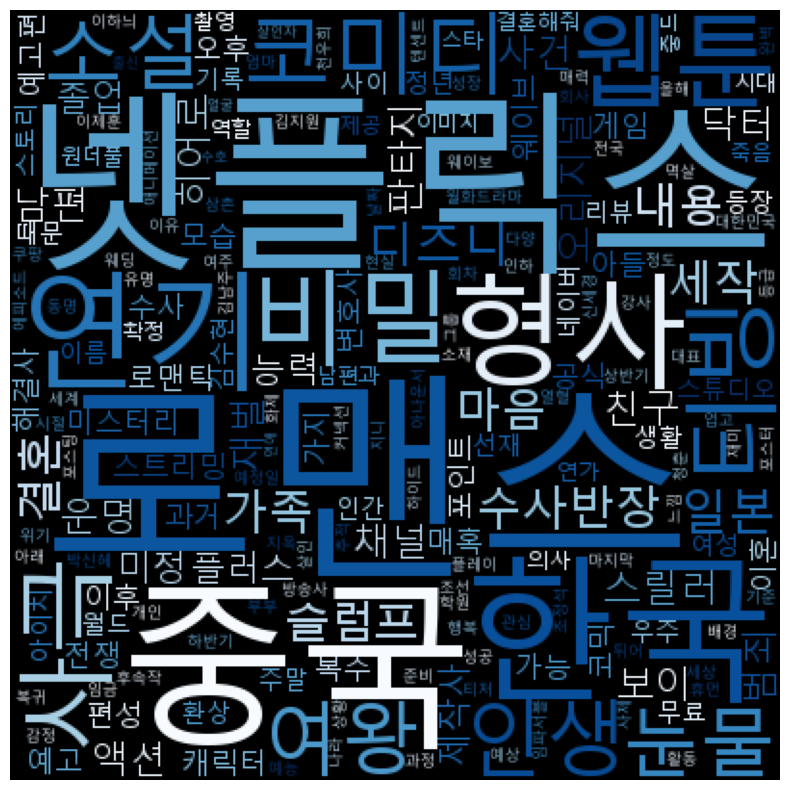

In [24]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

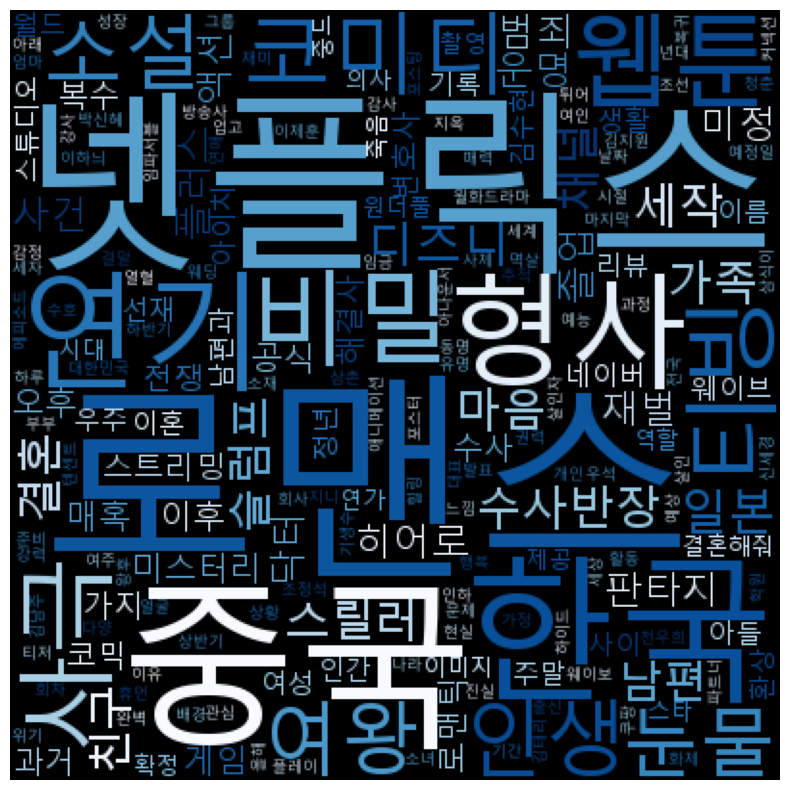

In [26]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'예고편', '스토리', '때문', '예고', '캐릭터', '편성', '후속작', '포인트', '무료',
             '보이', '기준', '성공', '제작사', '가능', '능력', '모습', '내용', '등장', '오리지널',
             '등급', '정도' }

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [27]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'한국': 67,
 '중국': 61,
 '웨이보': 58,
 '로맨스': 51,
 '텐센트': 46,
 '넷플릭스': 41,
 '아이치': 29,
 '채널': 28,
 '눈물': 27,
 '여왕': 26,
 '수사반장': 24,
 '사극': 23,
 '티빙': 23,
 '비밀': 23,
 '코미디': 22,
 '디즈니': 22,
 '히어로': 22,
 '형사': 21,
 '선재': 21,
 '매혹': 20,
 '세작': 20,
 '재벌': 20,
 '졸업': 20,
 '일본': 19,
 '판타지': 18,
 '인생': 18,
 '업고': 18,
 '튀어': 18,
 '오후': 18,
 '확정': 17,
 '바이두': 17,
 '도시': 17,
 '유쿠': 17,
 '상반기': 16,
 '기간': 16,
 '올해': 16,
 '날짜': 16,
 '닥터': 16,
 '슬럼프': 15,
 '주말': 15,
 '범죄': 15,
 '백과': 15,
 '편성': 15,
 '플러스': 15,
 '월드': 14,
 '하반기': 14,
 '웹툰': 14,
 '원더풀': 14,
 '방송사': 14,
 '소설': 14,
 '월화': 14,
 '스릴러': 13,
 '웨딩': 13,
 '액션': 13,
 '예고편': 13,
 '해결사': 13,
 '임파서블': 13,
 '목록': 12,
 '수사': 12,
 '리뷰': 12,
 '파트너': 12,
 '보이': 11,
 '오리지널': 11,
 '내용': 11,
 '결혼해줘': 11,
 '후속작': 11,
 '회차': 11,
 '공감': 11,
 '남편과': 11,
 '주간': 10,
 '망고': 10,
 '하이드': 10,
 '포스팅': 10,
 '환상': 10,
 '목표': 10,
 '연가': 10,
 '청춘': 10,
 '전쟁': 9,
 '가족': 9,
 '아나운서': 9,
 '사이': 9,
 '정년': 9,
 '연기': 9,
 '내년': 9,
 '마지막': 9,
 '예상': 8,
 '토요일': 8,
 '게임': 8,
 '기대작'

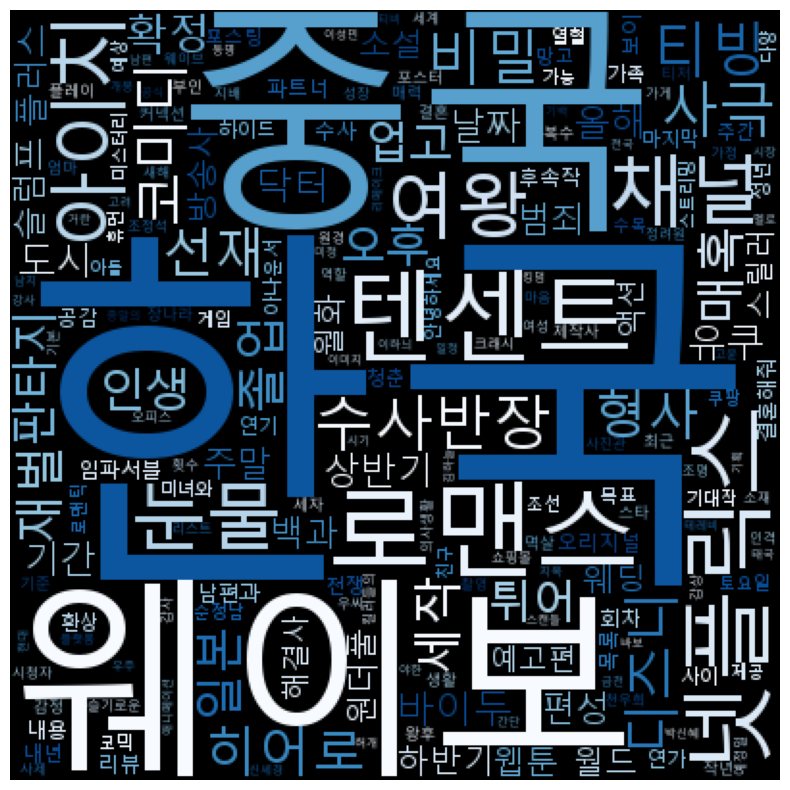

In [28]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

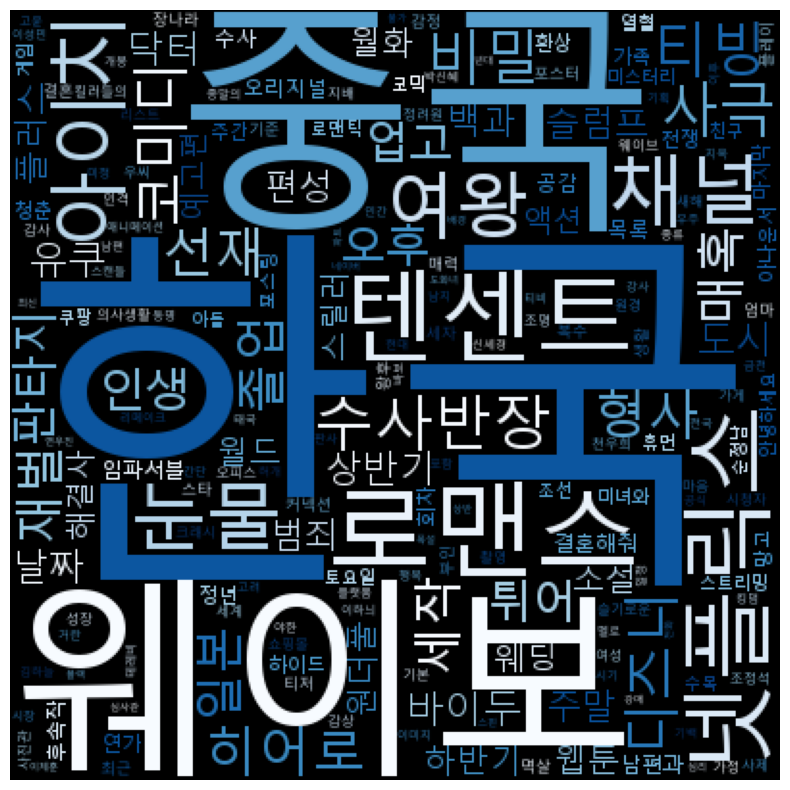

In [30]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'기간', '리뷰', '내용', '내년', '기대작', '방송사', '확정', '파트너', '가능', '보이',
             '다양', '사이', '제공', '작년', '예정일', '연기', '제작사', '소재', '목표', '횟수',
             '올해', '예상', '확정', '역할'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [31]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'중국': 96,
 '한국': 46,
 '넷플릭스': 27,
 '로맨스': 19,
 '눈물': 18,
 '여왕': 18,
 '웹툰': 17,
 '디즈니': 16,
 '수사반장': 15,
 '공지': 14,
 '세작': 13,
 '티빙': 13,
 '일본': 13,
 '졸업': 12,
 '사극': 12,
 '히어로': 12,
 '기대작': 11,
 '매혹': 10,
 '슬럼프': 10,
 '닥터': 10,
 '플러스': 10,
 '게임': 9,
 '비밀': 9,
 '예고편': 8,
 '지옥': 8,
 '월드': 8,
 '원더풀': 8,
 '확정': 8,
 '하이드': 7,
 '인생': 6,
 '업고': 6,
 '연가': 6,
 '환상': 6,
 '남편과': 6,
 '결혼해줘': 6,
 '선재': 6,
 '공식': 6,
 '튀어': 6,
 '소설': 6,
 '형사': 6,
 '재벌': 6,
 '일정': 6,
 '아이치': 5,
 '만화': 5,
 '채널': 5,
 '하반기': 5,
 '멱살': 5,
 '애니': 5,
 '쿠팡': 5,
 '열혈': 5,
 '코미디': 5,
 '유쿠': 5,
 '오리지널': 5,
 '티저': 5,
 '판타지': 5,
 '웨딩': 5,
 '편성': 5,
 '인사': 5,
 '사이': 5,
 '부활': 5,
 '사제': 5,
 '임파서블': 5,
 '해결사': 5,
 '주말': 5,
 '고윤': 5,
 '주제': 5,
 '살인자': 5,
 '파트너': 4,
 '판사': 4,
 '전쟁': 4,
 '세자': 4,
 '오징어': 4,
 '시기': 4,
 '정년': 4,
 '예측': 4,
 '월화드라마': 4,
 '잡힙시다': 4,
 '중드': 4,
 '연애': 4,
 '커넥션': 4,
 '지배': 4,
 '순정남': 4,
 '미정': 4,
 '미녀와': 4,
 '목록': 4,
 '멜로': 4,
 '이제훈': 4,
 '마블': 4,
 '최신': 4,
 '리뷰': 4,
 '김수현': 4,
 '플레이': 4,
 '한번': 4,
 '개봉': 4,


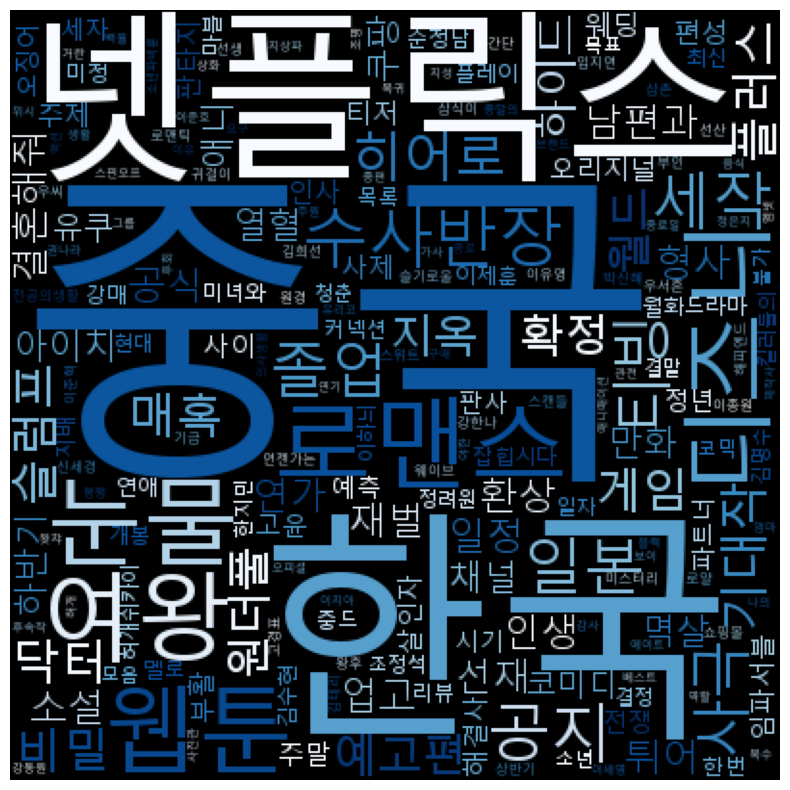

In [32]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

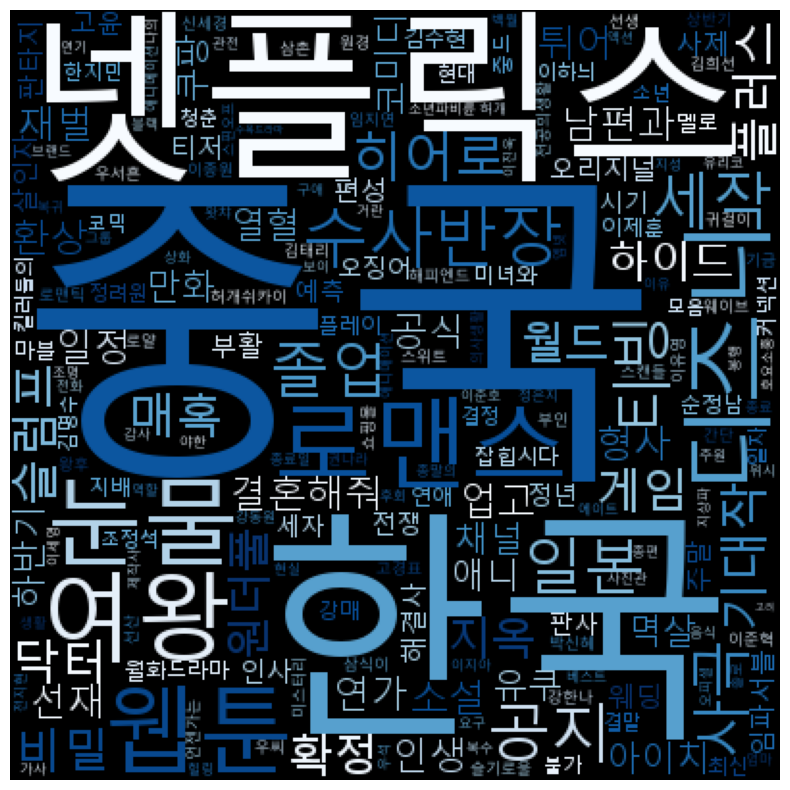

In [33]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'주제', '미정', '예고편', '리뷰', '한번', '파트너', '목표', '목록', '총편',
             '사이', '개봉', '후속작'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기